In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

In [41]:
# All tables/figures are built off the overall_hist_table
accuracy_results = pd.read_excel('partitioned_accuracy_results.xlsx')

## Table: CES-Weighted RMSE for Democratic Vote Share by Office and Year

In [42]:
df = accuracy_results[(accuracy_results['Party'] == 'Democrat') & 
        (accuracy_results['Metric'] == 'RMSE_0-100%') &
        (accuracy_results['Weighting.Method'] == 'CES-Provided Weights')]

# Pivot the dataframe to create a table with years as rows and races as columns
pivot_table = df.pivot_table(index='Year', columns='Race', values='Value', aggfunc='mean')

# 

# Reorder the columns and rename them according to the specified order and labels
column_order = ['President', 'US Senate', 'Governor', 'US House', 'Attorney General', 'Secretary of State', 'State Senator', 'State Representative']
column_labels = ['President', 'U.S. Senate', 'Governor', 'U.S. House', 'Attorney General', 'Secretary of State', 'State Senate', 'State Representative']

# Select and reorder the columns
pivot_table = pivot_table[column_order]

# Rename the columns
pivot_table.columns = column_labels

# Calculate the average across years and add it as a new row
pivot_table.loc['Average'] = pivot_table.mean()

# Calculate the average across races and add it as a new column
pivot_table['Average'] = pivot_table.mean(axis=1)

# Format the table: truncate to one decimal place, replace NaN with "-"
pivot_table = pivot_table.apply(lambda col: col.map(lambda x: f"{x:.1f}" if isinstance(x, (int, float)) else x)).fillna('-')
# Convert the pivot table to LaTeX format
latex_table = pivot_table.to_latex(
    caption='CES-Weighted RMSE for Democratic Vote Share by Office and Year',
    label='tab:rmse_by_race_year',
    column_format='l' + 'c' * (len(pivot_table.columns) - 1) + '|c',
    multirow=True,
    escape=False
)

# Print the LaTeX table
print(latex_table)


\begin{table}
\caption{CES-Weighted RMSE for Democratic Vote Share by Office and Year}
\label{tab:rmse_by_race_year}
\begin{tabular}{lcccccccc|c}
\toprule
 & President & U.S. Senate & Governor & U.S. House & Attorney General & Secretary of State & State Senate & State Representative & Average \\
Year &  &  &  &  &  &  &  &  &  \\
\midrule
2006 & nan & 7.2 & 5.1 & 5.3 & 13.0 & 10.4 & 10.9 & 6.7 & 8.4 \\
2008 & 3.5 & 4.9 & 5.2 & 6.2 & nan & nan & 6.1 & 5.0 & 5.2 \\
2010 & nan & 1.4 & 2.8 & 4.5 & 14.3 & 11.9 & 10.5 & 5.3 & 7.2 \\
2012 & 2.8 & 2.8 & 2.9 & 2.9 & 15.1 & 10.8 & 7.2 & 6.3 & 6.3 \\
2014 & nan & 2.9 & 6.2 & 4.1 & 7.9 & 10.4 & 12.9 & 5.7 & 7.2 \\
2016 & 1.6 & 3.5 & 3.8 & 3.4 & 4.6 & 9.3 & 7.6 & 5.9 & 5.0 \\
2018 & nan & 4.7 & 4.5 & 3.8 & 3.9 & 4.0 & 4.5 & 8.5 & 4.8 \\
2020 & 2.4 & 7.2 & 3.2 & 3.6 & 4.2 & 3.8 & 9.9 & 8.2 & 5.3 \\
2022 & nan & 9.3 & 6.9 & 5.7 & 4.0 & 4.4 & 10.0 & 10.4 & 7.3 \\
Average & 2.6 & 4.9 & 4.5 & 4.4 & 8.4 & 8.1 & 8.9 & 6.9 & 6.1 \\
\bottomrule
\end{tabular

## Table: Comparison of CES-Reported and Calculated RMSEs by Office and Year

In [43]:
# Filter the dataframe for Democrat party and RMSE from 0-100%
df = accuracy_results[(accuracy_results['Party'] == 'Democrat') & 
        (accuracy_results['Metric'] == 'RMSE_0-100%') &
        (accuracy_results['Weighting.Method'] == 'CES-Provided Weights') &
        (~accuracy_results['Race'].isin(['US House', 'State Representative', 'State Senator']))]

ces_reported_errors_df = pd.read_excel('CES_Reported_Errors.xlsx')

# # This was just to check that both dfs contained same races
# # Print unique values in the "Race" column for both dataframes
# print("Unique values in 'Race' column of df:")
# print(df['Race'].unique())

# print("Unique values in 'Race' column of ces_reported_errors_df:")
# print(ces_reported_errors_df['Race'].unique())

# # Check if they contain the same elements
# if set(df['Race'].unique()) == set(ces_reported_errors_df['Race'].unique()):
#     print("Both dataframes contain the same elements in the 'Race' column.")
# else:
#     print("The dataframes do not contain the same elements in the 'Race' column.")


# Merge the dataframe by Year and Race
comparison_df = pd.merge(df, ces_reported_errors_df, on=['Year', 'Race'])
comparison_df['Difference'] = comparison_df['Value'] - comparison_df['CES-Reported RMSE']

# Export the comparison dataframe to Excel
# comparison_df.to_excel('CES_Comparison_Results.xlsx', index=False)

def generate_latex_rmse_table(df, offices):
    """
    Given a DataFrame `df` with columns
      ['Year','Party','Weighting.Method','Metric','Value','Race',
       'Num_States','CES-Reported RMSE','Difference']
    and a list of `offices` (i.e. Race values) to include,  
    pivot it and print a LaTeX table comparing calculated vs CES‐reported RMSE.
    """
    # 1) Filter to the rows you care about
    sub = df[
        (df['Party'] == 'Democrat') &
        (df['Weighting.Method'] == 'CES-Provided Weights') &
        (df['Metric'] == 'RMSE_0-100%')
    ]

    # 2) Pivot so we have a MultiIndex of (Value, CES-Reported RMSE, Difference) × Race
    table = sub.pivot(
        index='Year',
        columns='Race',
        values=['Value', 'CES-Reported RMSE', 'Difference']
    )

    # 3) Build the two header lines
    #    e.g.  & \multicolumn{3}{c}{Attorney General} & \multicolumn{3}{c}{Secretary of State} \\
    hdr1 = " & " + " & ".join(
        rf"\multicolumn{{3}}{{c}}{{{office}}}" for office in offices
    ) + r" \\"
    #    Year & Calculated & CES-Reported & $\Delta$  repeated per office
    hdr2 = (
        "Year & " +
        " & ".join(["Calculated & CES-Reported & $\\Delta$"] * len(offices)) +
        r" \\"
    )

    # 4) Assemble the body rows, formatting to one decimal place
    rows = []
    for year in sorted(table.index):
        cells = [str(year)]
        for office in offices:
            v = table.loc[year, ('Value', office)]
            r = table.loc[year, ('CES-Reported RMSE', office)]
            d = table.loc[year, ('Difference', office)]
            cells += [f"{v:.1f}", f"{r:.1f}", f"{d:.1f}"]
        rows.append(" & ".join(cells) + r" \\")

    # 5) Put it all together
    ncols = 1 + 3 * len(offices)
    latex = []
    latex.append(r"\begin{table}[h!]")
    latex.append(r"\centering")
    latex.append(r"\caption{Comparison of CES-Reported and Calculated RMSEs by Office and Year}")
    latex.append(r"\begin{threeparttable}")
    latex.append(r"\begin{tabular}{" + "c" * ncols + "}")
    latex.append(r"\midrule")
    latex.append(r"\midrule")
    latex.append(hdr1)
    latex.append(r"\hline")
    latex.append(hdr2)
    latex.append(r"\hline")
    latex.extend(rows)
    latex.append(r"\midrule")
    latex.append(r"\end{tabular}")
    latex.append(r"\begin{tablenotes}")
    latex.append(r"  \footnotesize")
    latex.append(
        r"  \item \textit{Note:} All values are percents. 2008 and 2014 are excluded because the CES does not report "
        r"the accuracy of any non-weight-generation offices in these years. The delta shows (Calculated – CES-Reported) RMSE."
    )
    latex.append(r"\end{tablenotes}")
    latex.append(r"\end{threeparttable}")
    latex.append(r"\label{tab:cesvsme}")
    latex.append(r"\end{table}")

    print("\n".join(latex))


# Example usage:
offices = ["President", "US Senate", "Governor", "Attorney General", "Secretary of State"]
generate_latex_rmse_table(comparison_df, offices)



\begin{table}[h!]
\centering
\caption{Comparison of CES-Reported and Calculated RMSEs by Office and Year}
\begin{threeparttable}
\begin{tabular}{cccccccccccccccc}
\midrule
\midrule
 & \multicolumn{3}{c}{President} & \multicolumn{3}{c}{US Senate} & \multicolumn{3}{c}{Governor} & \multicolumn{3}{c}{Attorney General} & \multicolumn{3}{c}{Secretary of State} \\
\hline
Year & Calculated & CES-Reported & $\Delta$ & Calculated & CES-Reported & $\Delta$ & Calculated & CES-Reported & $\Delta$ & Calculated & CES-Reported & $\Delta$ & Calculated & CES-Reported & $\Delta$ \\
\hline
2006 & nan & nan & nan & 7.2 & 4.3 & 2.9 & 5.1 & 2.2 & 2.9 & 13.0 & 4.3 & 8.7 & 10.4 & 4.4 & 6.1 \\
2008 & 3.5 & 2.4 & 1.0 & nan & nan & nan & 5.2 & 3.2 & 2.0 & nan & nan & nan & nan & nan & nan \\
2010 & nan & nan & nan & 1.4 & 1.3 & 0.1 & 2.8 & 2.2 & 0.6 & 14.3 & 5.0 & 9.2 & 11.9 & 4.5 & 7.4 \\
2012 & 2.8 & 3.3 & -0.5 & 2.8 & 3.7 & -0.8 & nan & nan & nan & 15.1 & 16.9 & -1.8 & 10.8 & 9.9 & 0.8 \\
2014 & nan & nan & na

## Figure: RMSE by Race Competetiveness

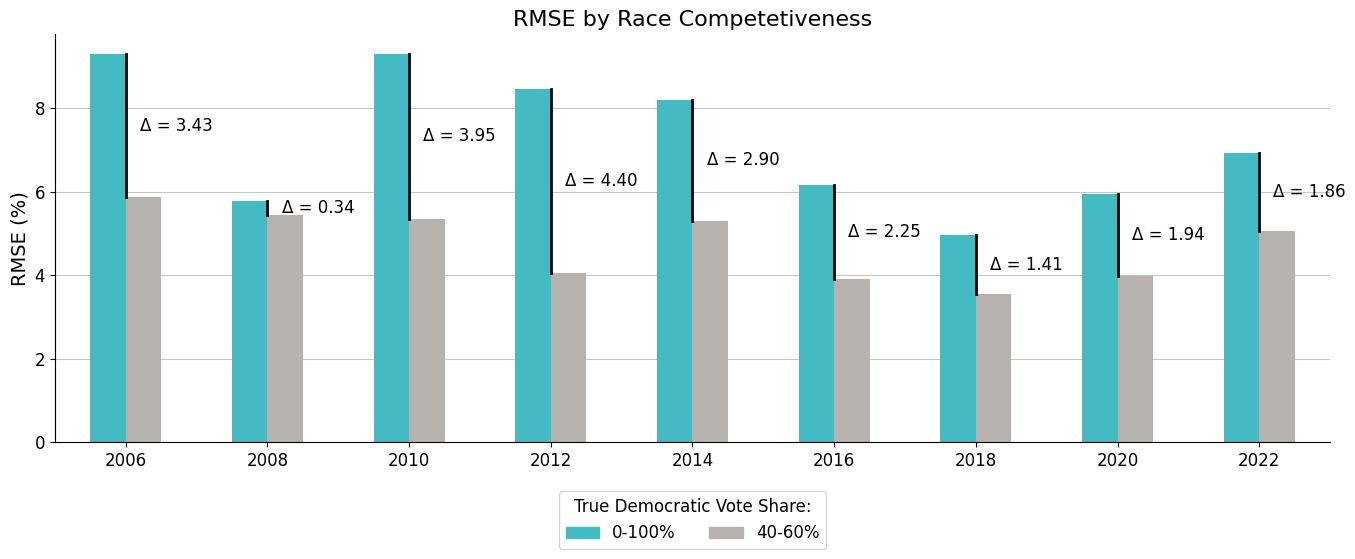

In [44]:
# Filter dataframe to include only Democrat party and RMSE from 0-100%
df_0_100 = accuracy_results[(accuracy_results['Party'] == 'Democrat') & 
              (accuracy_results['Metric'] == 'RMSE_0-100%') & 
              (accuracy_results['Weighting.Method'] == 'CES-Provided Weights') &
              (~accuracy_results['Race'].isin(['US Senate', 'President', 'Governor']))]

# Filter dataframe to include only Democrat party and RMSE from 40-60%
df_40_60 = accuracy_results[(accuracy_results['Party'] == 'Democrat') & 
               (accuracy_results['Metric'] == 'RMSE_40-60%') & 
               (accuracy_results['Weighting.Method'] == 'CES-Provided Weights') &
               (~accuracy_results['Race'].isin(['US Senate', 'President', 'Governor']))]


# Compute the average RMSE for each year
average_rmse_0_100 = df_0_100.groupby('Year')['Value'].mean()
average_rmse_40_60 = df_40_60.groupby('Year')['Value'].mean()

# Combine the two averages into a single DataFrame
average_rmse = pd.DataFrame({
    'RMSE_0-100': average_rmse_0_100,
    'RMSE_40-60': average_rmse_40_60
})

# Plotting the histogram
colors = ['#44bbc3', '#b8b2ae']  # New color palette for two bars
ax = average_rmse.plot(kind='bar', figsize=(14, 6), color=colors, zorder=2)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set X-axis labels to be full years and horizontal
ax.set_xticklabels(average_rmse.index, rotation=0)

# Add axis labels and set title to blank with larger font size
plt.xlabel('', fontsize=14)
plt.ylabel('RMSE (%)', fontsize=14)
plt.title('RMSE by Race Competetiveness', fontsize=16)

# Add horizontal grid lines behind the bars
plt.grid(axis='y', linestyle='-', alpha=0.7, zorder=1)

# Set tick parameters for larger font sizes
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add a black bracket that spans the height of the difference between the two bars
for i in range(len(average_rmse)):
    y1 = average_rmse.iloc[i]['RMSE_0-100']
    y2 = average_rmse.iloc[i]['RMSE_40-60']
    plt.plot([i, i], [min(y1, y2), max(y1, y2)], color='black', lw=2)  # Vertical line
    plt.text(i + 0.1, (min(y1, y2) + max(y1, y2)) / 2, f'Δ = {abs(y1 - y2):.2f}', ha='left', va='center', fontsize=12, color='black')

# Move legend to bottom and make it horizontal with larger font size
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]  # Create colored squares for legend
plt.legend(handles=handles, title='True Democratic Vote Share:', labels=['0-100%', '40-60%'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=12, title_fontsize=12)

# Adjust layout to make room for the legend and reduce extra space
plt.tight_layout(pad=2.0)

# Save the plot as a file
plt.savefig('figures/rmsebyracecomp.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Figure: RMSE by Weighting Method

Weighting.Method  ANESRake  CES-Provided Weights  CES-Unweighted
Year                                                            
2006              9.573289              9.291667        9.064924
2008              6.654786              5.776043        6.438433
2010              9.656323              9.298596        9.091345
2012              8.807676              8.450091        8.133542
2014              9.494662              8.199557        9.424410
2016              8.066686              6.162681        7.928432
2018              7.211038              4.949667        7.538012
2020              9.372560              5.932198       11.409769
2022              9.757642              6.915806       11.161002


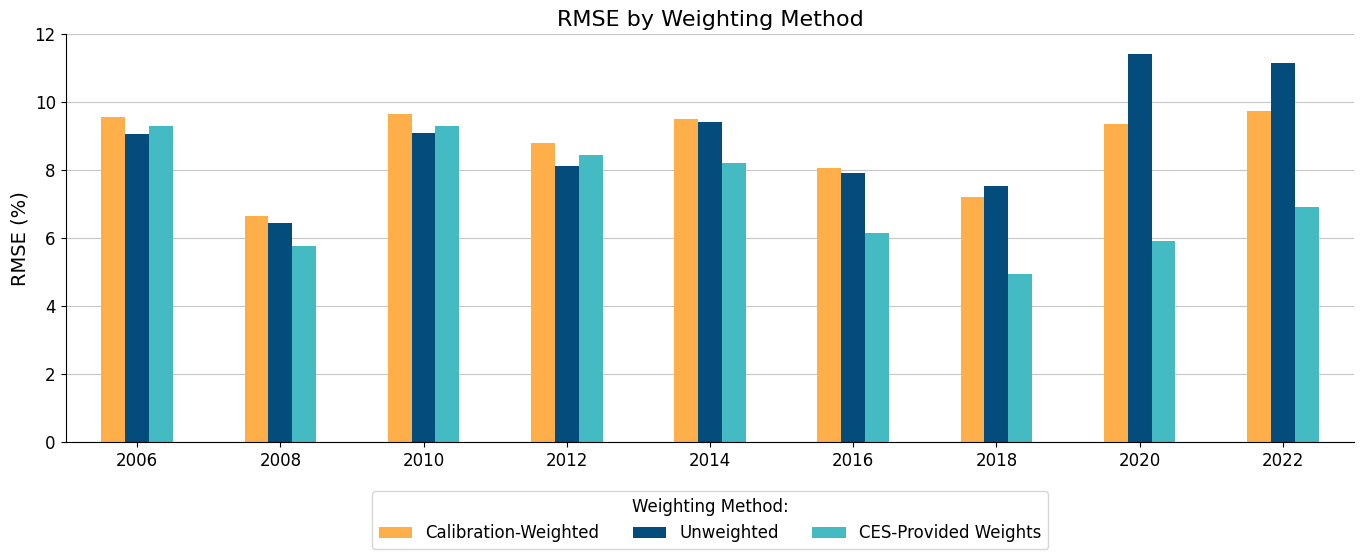

In [45]:
# Filter dataframe to include only Democrat party and RMSE from 0-100%
df = accuracy_results[(accuracy_results['Party'] == 'Democrat') & 
        (accuracy_results['Metric'] == 'RMSE_0-100%') & 
        (~accuracy_results['Race'].isin(['US Senate', 'President', 'Governor']))]

# Compute the average RMSE for each year and weighting method
average_rmse = df.groupby(['Year', 'Weighting.Method'])['Value'].mean().unstack()

print(average_rmse)

# Ensure the columns are in the order: ANESRake, CES-Unweighted, CES-Provided Weights
column_order = ['ANESRake', 'CES-Unweighted', 'CES-Provided Weights']
average_rmse = average_rmse[column_order]

# Plotting the histogram
colors = ['#ffaf49', '#044c7c', '#44bbc3']  # New color palette
ax = average_rmse.plot(kind='bar', figsize=(14, 6), color=colors, zorder=2)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set X-axis labels to be full years and horizontal
ax.set_xticklabels(average_rmse.index, rotation=0)

# Add axis labels and set title to blank with larger font size
plt.xlabel('', fontsize=14)
plt.ylabel('RMSE (%)', fontsize=14)
plt.title('RMSE by Weighting Method', fontsize=16)

# Add horizontal grid lines behind the bars with a maximum at 12
ax.set_ylim(0, 12)
plt.grid(axis='y', linestyle='-', alpha=0.7, zorder=1)

# Set tick parameters for larger font sizes
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Move legend to bottom and make it horizontal with larger font size
plt.legend(title='Weighting Method:', labels=['Calibration-Weighted', 'Unweighted', 'CES-Provided Weights'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12, title_fontsize=12)

# Adjust layout to make room for the legend and reduce extra space
plt.tight_layout(pad=2.0)

# Save the plot as a file
plt.savefig('figures/average_rmse_histogram.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Unused Figure: RMSE Reductions in CES by Independence Condition

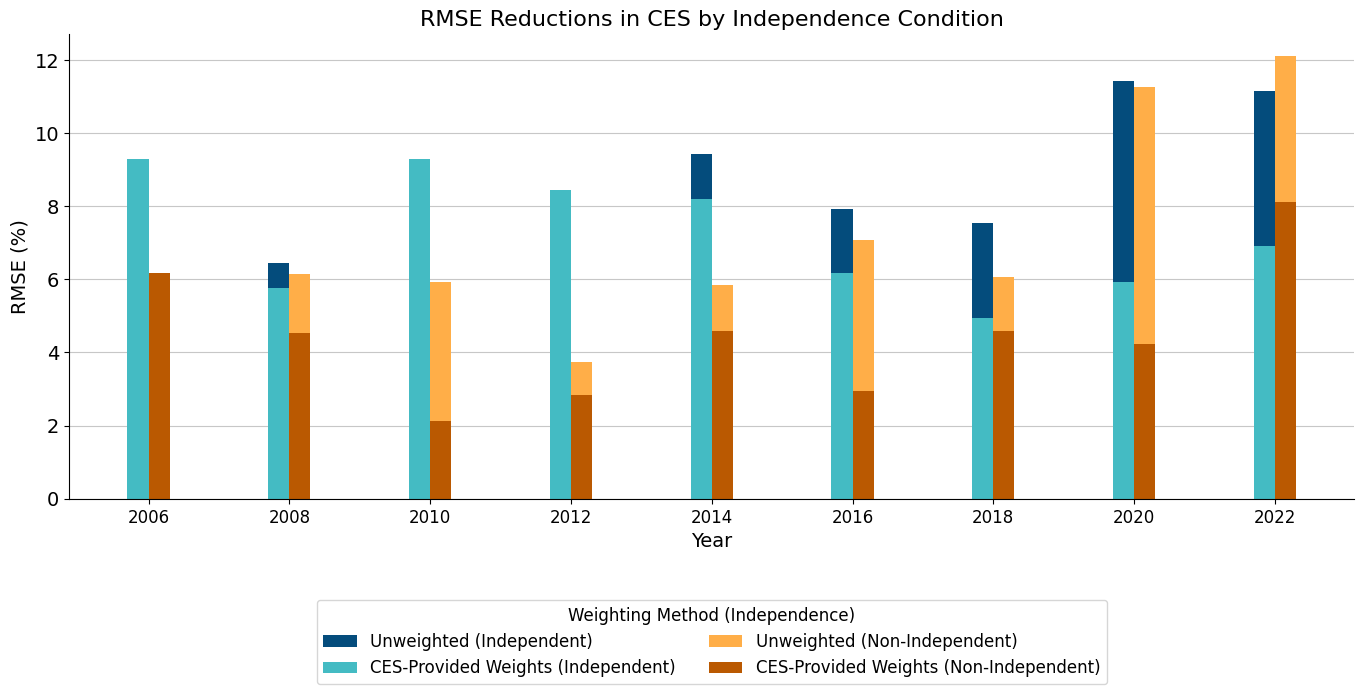

In [46]:
# Filter dataframe to include only Democrat party and RMSE from 0-100%
# Non-Governor, US Senate, President races
df_non_included = accuracy_results[(accuracy_results['Party'] == 'Democrat') & 
                     (accuracy_results['Metric'] == 'RMSE_0-100%') & 
                     (~accuracy_results['Race'].isin(['Governor', 'US Senate', 'President']))].copy()

# Included races: Governor, US Senate, President
df_included = accuracy_results[(accuracy_results['Party'] == 'Democrat') & 
                (accuracy_results['Metric'] == 'RMSE_0-100%') & 
                (accuracy_results['Race'].isin(['Governor', 'US Senate', 'President']))].copy()

# Ensure 'Year' is integer to avoid decimal years
df_non_included['Year'] = df_non_included['Year'].astype(int)
df_included['Year'] = df_included['Year'].astype(int)

# print("Non-Included Races:")
# print(df_non_included)

# print("Included Races:")
# print(df_included)

# Compute the average RMSE for each year across all races
year_df_non = df_non_included.groupby(['Year', 'Weighting.Method'])['Value'].mean().unstack()
# print("Non-Included Yearly RMSE:")
# print(year_df_non)

year_df_incl = df_included.groupby(['Year', 'Weighting.Method'])['Value'].mean().unstack()
# print("Included Yearly RMSE:")
# print(year_df_incl)

# Ensure years are in chronological order
year_df_non = year_df_non.sort_index()
year_df_incl = year_df_incl.sort_index()
#print("Sorted Non-Included Yearly RMSE:")
#print(year_df_non)

#print("Sorted Included Yearly RMSE:")
#print(year_df_incl)

# Compute the RMSE reduction for CES Weighted and CES Unweighted
year_df_non['Improvement'] = year_df_non['CES-Unweighted'] - year_df_non['CES-Provided Weights']
year_df_incl['Improvement'] = year_df_incl['CES-Unweighted'] - year_df_incl['CES-Provided Weights']

# Plot RMSE reductions for each year
fig1, ax1 = plt.subplots(figsize=(14, 8))

# Remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add solid lines at y-axis tick marks and make numbers larger
ax1.yaxis.grid(True, linestyle='-', alpha=0.7, zorder=0)
ax1.tick_params(axis='y', labelsize=14)

# Set bar width and positions
bar_width = 0.15  # Reduced from 0.2
years = year_df_non.index.astype(str)
x = np.arange(len(years))

# Plot the CES-Unweighted and CES-Provided Weights for non-included races
ax1.bar(x - bar_width/2, year_df_non['CES-Unweighted'], width=bar_width, color='#044c7c', label='Unweighted (Independent)', zorder=2)
ax1.bar(x - bar_width/2, year_df_non['CES-Provided Weights'], width=bar_width, color='#44bbc3', label='CES-Provided Weights (Independent)', zorder=2)

# Plot the CES-Unweighted and CES-Provided Weights for included races
ax1.bar(x + bar_width/2, year_df_incl['CES-Unweighted'], width=bar_width, color='#ffae48', label='Unweighted (Non-Independent)', zorder=2)
ax1.bar(x + bar_width/2, year_df_incl['CES-Provided Weights'], width=bar_width, color='#ba5901', label='CES-Provided Weights (Non-Independent)', zorder=2)

# Add the text annotations for improvements with larger font size
# for i, (row_non, row_incl) in enumerate(zip(year_df_non.itertuples(), year_df_incl.itertuples())):
#     # Non-included improvement
#     ax1.annotate(f"-{row_non.Improvement:.2f}%", 
#                 xy=(i - bar_width/2, max(row_non._2, row_non._3)),
#                 xytext=(-20, 15), textcoords='offset points',
#                 ha='right', va='bottom', fontsize=12,
#                 arrowprops=dict(arrowstyle='-', color='black', linewidth=0.5))
    
#     # Included improvement  
#     ax1.annotate(f"-{row_incl.Improvement:.2f}%",
#                 xy=(i + bar_width/2, max(row_incl._2, row_incl._3)), 
#                 xytext=(20, 15), textcoords='offset points',
#                 ha='left', va='bottom', fontsize=12,
#                 arrowprops=dict(arrowstyle='-', color='black', linewidth=0.5))

# Customize the plot
ax1.set_title("RMSE Reductions in CES by Independence Condition", fontsize=16)
ax1.set_xlabel("Year", fontsize=14)
ax1.set_ylabel("RMSE (%)", fontsize=14)
plt.setp(ax1.get_xticklabels(), rotation=0, ha="center", fontsize=12)

# Explicitly set x-axis ticks to integer years
ax1.set_xticks(x)
ax1.set_xticklabels(years, fontsize=12)

ax1.legend(title="Weighting Method (Independence)", title_fontsize='12', fontsize='12', 
          loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

# Adjust the layout with more padding at the bottom
plt.tight_layout(pad=2.0, rect=[0, 0.05, 1, 1])

# Save the plot
plt.savefig("figures/rmse_improvement_by_year.png", dpi=300)

# Show the plot
plt.show()

## Figure: RMSE Reductions Due to Weighting by Year

Average CES-Weighted RMSE by Year:
Year
2006    9.291667
2008    5.776043
2010    9.298596
2012    8.450091
2014    8.199557
2016    6.162681
2018    4.949667
2020    5.932198
2022    6.915806
Name: CES-Provided Weights, dtype: float64


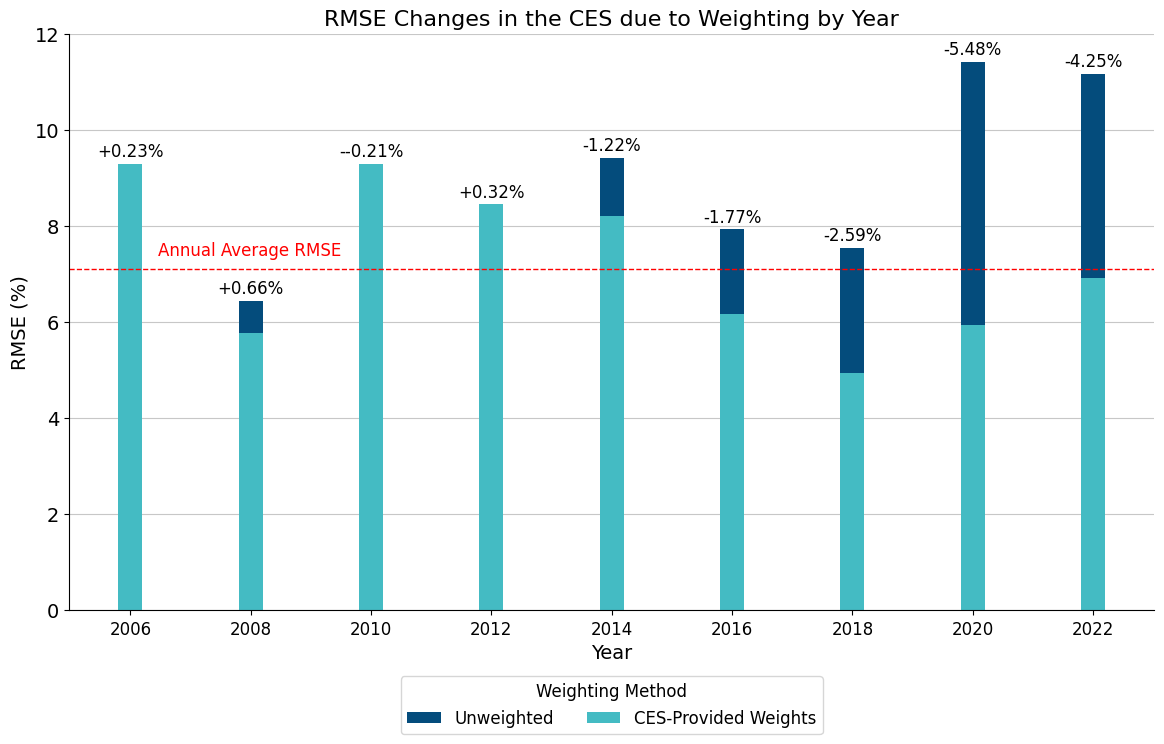

In [47]:
# Filter dataframe to include only Democrat party and RMSE from 0-100%
df_filtered = accuracy_results[(df['Party'] == 'Democrat') & 
                (accuracy_results['Metric'] == 'RMSE_0-100%') &
                (~accuracy_results['Race'].isin(['Governor', 'US Senate', 'President']))].copy()

# Ensure 'Year' is integer to avoid decimal years
df_filtered['Year'] = df_filtered['Year'].astype(int)

#print(df_filtered)

# Compute the average RMSE across all races for each year and weighting method
year_df = df_filtered.groupby(['Year', 'Weighting.Method'])['Value'].mean().unstack()
#print(year_df)

# Print the average CES-weighted RMSE by year
ces_weighted_rmse = year_df['CES-Provided Weights']
print("Average CES-Weighted RMSE by Year:")
print(ces_weighted_rmse)

# Ensure years are in chronological order
year_df = year_df.sort_index()
#print(year_df)

# Compute the RMSE reduction for CES Weighted and CES Unweighted
year_df['Improvement'] = year_df['CES-Unweighted'] - year_df['CES-Provided Weights']

# Plot RMSE reductions for each year
fig1, ax1 = plt.subplots(figsize=(12, 8))

# Remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add solid lines at y-axis tick marks and make numbers larger
ax1.yaxis.grid(True, linestyle='-', alpha=0.7, zorder=0)
ax1.tick_params(axis='y', labelsize=14)

# Set the y-axis limit to ensure the maximum horizontal grid line is at 12
ax1.set_ylim(0, 12)

# Plot the CES-Unweighted RMSE bars
ax1.bar(year_df.index, year_df['CES-Unweighted'], color='#044c7c', width=0.4, label='Unweighted', zorder=2)

# Plot the CES Weighted RMSE bars on top of the unweighted bars with the same width
ax1.bar(year_df.index, year_df['CES-Provided Weights'], color='#44bbc3', width=0.4, label='CES-Provided Weights', zorder=2)
# Plot a horizontal line with the average across all years
ax1.axhline(y=7.1, color='red', linestyle='--', linewidth=1)

# Add the label "Annual Average RMSE" without the arrow
x_position = year_df.index[int(len(year_df.index) * 0.25)]
ax1.text(x_position - .5, 7.5, 'Annual Average RMSE', fontsize=12, color='red', ha='right', va='center')

# Add the text annotations for improvements with larger font size
for i, row in enumerate(year_df.itertuples()):
    improvement_label = f"-{row.Improvement:.2f}%" if row.Index not in [2006, 2008, 2012] else f"+{abs(row.Improvement):.2f}%"
    ax1.text(row.Index, max(row._2, row._3) + 0.15, 
             improvement_label, color='black', ha="center", fontsize=12)

# Customize the plot
ax1.set_title("RMSE Changes in the CES due to Weighting by Year", fontsize=16)
ax1.set_xlabel("Year", fontsize=14)
ax1.set_ylabel("RMSE (%)", fontsize=14)
plt.setp(ax1.get_xticklabels(), rotation=0, ha="center", fontsize=12)

# Explicitly set x-axis ticks to integer years
ax1.set_xticks(year_df.index)
ax1.set_xticklabels(year_df.index.astype(int).astype(str), fontsize=12)

ax1.legend(title="Weighting Method", title_fontsize='12', fontsize='12', 
          loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Adjust the layout with less padding at the bottom
plt.tight_layout(pad=2.0, rect=[0, 0.02, 1, 1])

# Save the plot
plt.savefig("figures/rmse_improvement_by_year.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


## RMSE Reductions Due to Weighting by Office

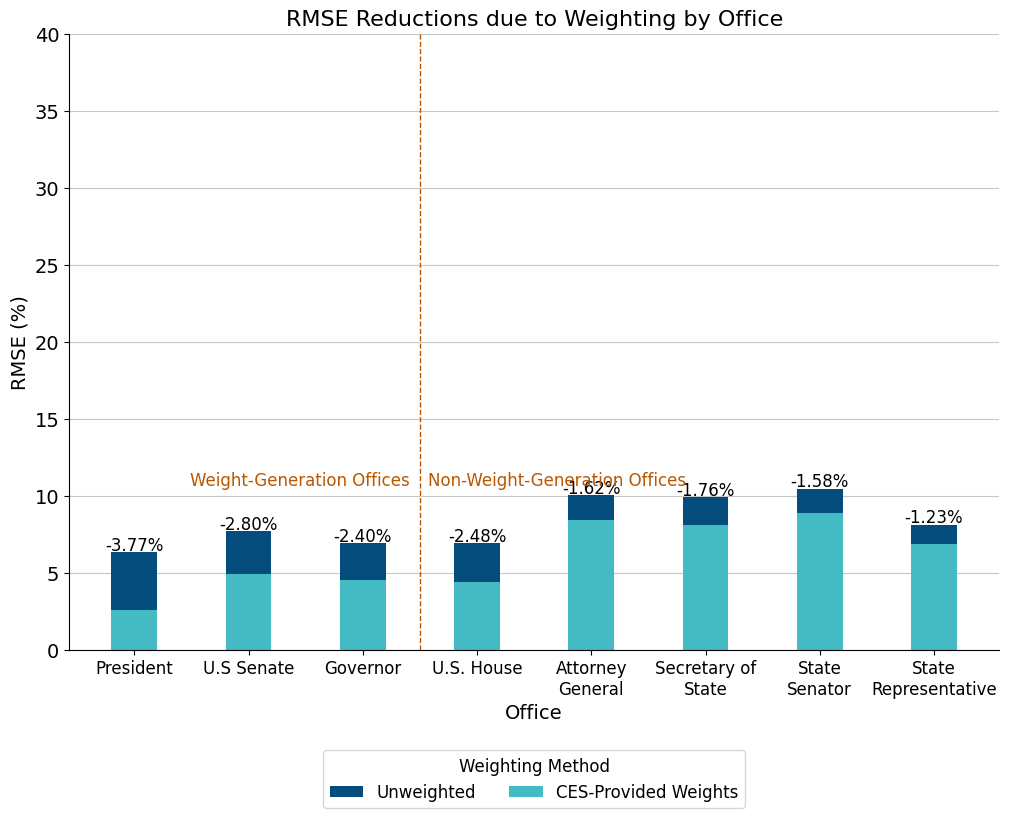

In [48]:
# Filter dataframe to include only Democrat party, RMSE from 0-100%, and exclude 'anesrake'
df_filtered = accuracy_results[(accuracy_results['Party'] == 'Democrat') & 
                 (accuracy_results['Metric'] == 'RMSE_0-100%') & 
                 (accuracy_results['Weighting.Method'] != 'ANESRake')]

#print(df_filtered)

# Compute the average RMSE for each race across all years
race_df = df_filtered.groupby(['Race', 'Weighting.Method'])['Value'].mean().unstack()
#print(race_df)

# Reorder the races and format labels with line breaks
labels = ['President', 'U.S Senate', 'Governor', 'U.S. House', 'Attorney\nGeneral', 'Secretary of\nState', 'State\nSenator', 'State\nRepresentative']
desired_order = ['President', 'US Senate', 'Governor', 'US House', 'Attorney General', 'Secretary of State', 'State Senator', 'State Representative']
race_df = race_df.reindex(desired_order)

# Compute the RMSE reduction for CES Weighted and CES Unweighted
race_df['Improvement'] = race_df['CES-Unweighted'] - race_df['CES-Provided Weights']

# Plot RMSE reductions for each race across all years
fig1, ax1 = plt.subplots(figsize=(12, 8))

# Remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add solid lines at y-axis tick marks and make numbers larger
ax1.yaxis.grid(True, linestyle='-', alpha=0.7, zorder=0)  # Changed zorder to 0
ax1.tick_params(axis='y', labelsize=14)

# Set the y-axis limit to ensure the max horizontal grid line is at 12%
ax1.set_ylim(0, 40)


# Plot the CES-Unweighted RMSE bars
ax1.bar(labels, race_df['CES-Unweighted'], color='#044c7c', width=0.4, label='Unweighted', zorder=2)

# Plot the CES Weighted RMSE bars on top of the unweighted bars with the same width
ax1.bar(labels, race_df['CES-Provided Weights'], color='#44bbc3', width=0.4, label='CES-Provided Weights', zorder=2)

# Add the text annotations for improvements with larger font size
for i, row in enumerate(race_df.itertuples()):
    ces_unweighted = row._1
    ces_provided_weights = row._2
    ax1.text(labels[i], max(ces_unweighted, ces_provided_weights) + 0.15, 
             f"-{row.Improvement:.2f}%", color='black', ha="center", fontsize=12)  # Increased fontsize from default to 14
# Add a vertical line between Governor and US House
ax1.axvline(x=2.5, color='#ba5700', linestyle='--', linewidth=1)

# Add a label for Weight-Generation Offices
ax1.text(1.45, 11, "Weight-Generation Offices", fontsize=12, color='#ba5700', ha='center', va='center', rotation='horizontal')
ax1.text(3.7, 11, "Non-Weight-Generation Offices", fontsize=12, color='#ba5700', ha='center', va='center', rotation='horizontal')
# Customize the plot
ax1.set_title("RMSE Reductions due to Weighting by Office", fontsize=16)
ax1.set_xlabel("Office", fontsize=14)
ax1.set_ylabel("RMSE (%)", fontsize=14)
plt.setp(ax1.get_xticklabels(), rotation=0, ha="center", fontsize=12)

ax1.legend(title="Weighting Method", title_fontsize='12', fontsize='12', 
          loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Adjust the layout with less padding at the bottom
#plt.tight_layout(pad=2.0, rect=[0, 0.1, 1, 1])

# Save the plot
plt.savefig("figures/rmse_improvement_by_race.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Figure: Modal Category Population Estimates in CPS and CES 

['60k-100k' 'South' 'Employed' 'Voted' 'In person' 'Not current member'
 'Non-veteran' 'Citizen']


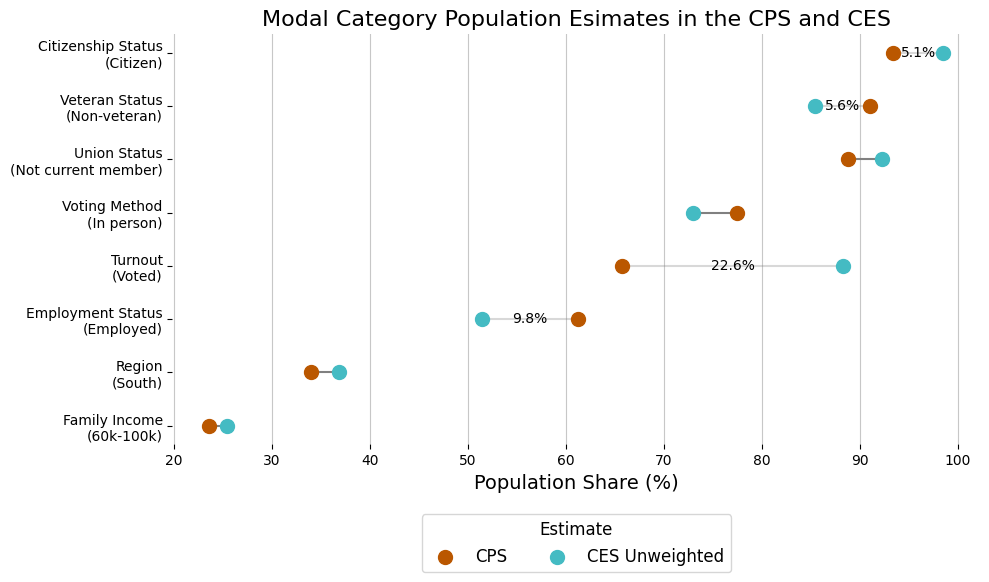

In [49]:
# Load the data
average_modal_summary = pd.read_excel('demographic_modal_summary.xlsx')

# Exclude specified variables
average_modal_summary = average_modal_summary[~average_modal_summary['Variable'].isin(['HISPAN_rc', 'AGE_GROUP_rc', 'SEX_rc', 'EDUC_rc'])]

# Sort the data by CPS percentage in increasing order
average_modal_summary = average_modal_summary.sort_values(by='Average_CPS')

# Mapping for category labels
category_mapping = {
    'CITIZEN_rc': 'Citizenship Status',
    'EDUC_rc': 'Highest Education',
    'EMPSTAT_rc': 'Employment Status',
    'FAMINC_rc': 'Family Income',
    'REGION_rc': 'Region',
    'VOTEHOW_rc': 'Voting Method',
    'VOTED_rc': 'Turnout',
    'UNION_rc': 'Union Status',
    'VETSTAT_rc': 'Veteran Status'
}

# Apply the mapping to change category labels
average_modal_summary['Variable'] = average_modal_summary['Variable'].map(category_mapping)

# Change specific category names
average_modal_summary['Category'] = average_modal_summary['Category'].replace({
    'Not current union member': 'Not current member',
    '$60 000 - $99 999': '60k-100k'
})

# print unique categories
print(average_modal_summary['Category'].unique())

# Create the dot plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the CPS percentages
ax.scatter(average_modal_summary['Average_CPS'], average_modal_summary['Variable'], color='#ba5700', label='CPS', s=100, zorder=3)

# Plot the CES Unweighted percentages
ax.scatter(average_modal_summary['Average_CES_Unweighted'], average_modal_summary['Variable'], color='#44bbc3', label='CES Unweighted', s=100, zorder=3)

# Add connecting lines between the dots and labels for differences exceeding 5%
for i, row in average_modal_summary.iterrows():
    difference = abs(row['Average_CPS'] - row['Average_CES_Unweighted'])
    line_color = 'gray' if difference <= 5 else 'gray'  # Default color is gray
    line_alpha = 1.0 if difference <= 5 else 0.3  # Make line transparent if difference exceeds 5%
    ax.plot([row['Average_CPS'], row['Average_CES_Unweighted']], [row['Variable'], row['Variable']], color=line_color, linestyle='-', zorder=2, alpha=line_alpha)
    if difference > 5:
        ax.text((row['Average_CPS'] + row['Average_CES_Unweighted']) / 2, row['Variable'], f"{difference:.1f}%", 
                color='black', ha='center', va='center', fontsize=10)

# Customize the y-axis to include both the variable and the category on separate lines
ax.set_yticks(average_modal_summary['Variable'])
ax.set_yticklabels([
    f"{row['Variable']}\n({row['Category']})"
    for _, row in average_modal_summary.iterrows()
], fontsize=10)  # Remove bold from y-axis labels

# Customize the plot
ax.set_xlabel('Population Share (%)', fontsize=14)
ax.set_ylabel('', fontsize=14)  # Make y-axis label bold
ax.set_title('Modal Category Population Esimates in the CPS and CES', fontsize=16)

# Move the legend to be horizontal below the figure
ax.legend(title='Estimate', title_fontsize='12', fontsize='12', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Show grid lines
ax.xaxis.grid(True, linestyle='-', alpha=0.7, zorder=0)

# Remove plot borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig("figures/dot_plot_cps_ces_unweighted.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()